# Assignment 1b

In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (7,5)

In [10]:
class log_reg:
    """
    link_function: specifies the link function. Possible values are
                   "sigmoid" and "softmax"
    
    batch_size: int. Specify the sample size of each bin. Uses np.array_split to avoid
                exception due to not even split possible.  Set to None to avoid it.
                   
    note: working under the assumption that the rows and columns of
          the data corresponds to observations and variables respectively
    """
    def __init__(self, step_size = 0.01, epochs = 10000, random_init = False, 
                activation_function = "sigmoid", batch_size = None):
        self.step_size = step_size
        self.epochs = epochs
        self.random_init = random_init
        self.activation_function = activation_function
        self.batch_size = batch_size
        
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def softmax(self, z):
        """
        Using normalization as done here
        https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
        """
        s = np.max(z, axis=1).reshape(z.shape[0], 1)
        e_x = np.exp(z - s)
        div = np.sum(e_x, axis=1).reshape(z.shape[0], 1)
        return e_x / div
    
    def loss(self, p, y):
        if np.size(y.shape) == 1:
            # y has been supplied as 1d array
            return (-y * np.log(p) - (1-y) * np.log(1-p)).mean()
        else:
            # if y is 2d, the loss function can ge used for K = 2 also
            return (-1 / y.shape[0]) * np.sum(y * np.log(p))
            
    def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis = 1)
    
    def undo_one_hot(self, y):
        """
        Undoes one-hot-encoding of target vector
        to calculate prediction accuracy
        """
        return np.argmax(y, axis  = 1)
        
    def fit(self, X, y):
        # add an intercept for the b term
        X = self.add_intercept(X)
        
        # initialize the weight matrix
        k = y.shape[1]
        if self.random_init:
            self.w = np.random.normal(0, .01, k * X.shape[1]).reshape(X.shape[1], k)
        else:
            self.w = np.zeros(k * X.shape[1]).reshape(X.shape[1], k)
        
        # take into account the batch size, will create a split either way
        # but if batch_size is None then it will be a list of one element
        if self.batch_size is None:
            X_list = np.array_split(X, np.round(X.shape[0]/X.shape[0]))
            y_list = np.array_split(y, np.round(X.shape[0]/X.shape[0]))
        elif self.batch_size is not None:
            X_list = np.array_split(X, np.round(X.shape[0]/self.batch_size))
            y_list = np.array_split(y, np.round(X.shape[0]/self.batch_size))
        
        #  model fitting
        for i in range(self.epochs):
            gradient = 0
            for j in range(len(X_list)):
                z = X_list[j].dot(self.w)
            
                # activation function
                if self.activation_function.lower() == "sigmoid":
                    p = self.sigmoid(z)
                else:
                    p = self.softmax(z)
                
            # compute the gradient for batch j
                gradient +=  X_list[j].T.dot(p - y_list[j]) / X.shape[0]
            # update the weight matrix
            self.w -= self.step_size * gradient     
            
            # update and compute loss
            z = np.dot(X, self.w)
            # not very efficient
            if self.activation_function.lower() == "sigmoid":
                p = self.sigmoid(z)
            else:
                p = self.softmax(z)
            loss = self.loss(p, y)
    
    def predict(self, X, p_cutoff = .5):
        X = self.add_intercept(X)
        predicted_prob = self.sigmoid(np.dot(X, self.w))
        return predicted_prob >= p_cutoff

The log_reg class is what I used in assignment 1a.

## Exercise 2.1
We are now looking at the multinomial distribution with $K$ possible outcomes. That is, our data is of the form $\{\mathbf{x}_i, y_i\}_{i=1}^n$ where $y_i \in \{1, \ldots, K\}$. 

For this end, I will use the softmax function which is defined as
$$
p_i^{(k)} = \frac{\exp\left\{ \mathbf{w}_{(k)}^T \mathbf{x}_i + b\right\}}{\sum_{j=1}^K\exp\left\{ \mathbf{w}_{(j)}^T \mathbf{x}_i + b \right\}},
$$
where $p_i^{(k)} = P(\mathbf{y}_{(i)} = k| \mathbf{x}_i, \mathbf{w})$, and $\mathbf{w}$ is now $p \times K$. This means that
$$
p_i = \frac{1}{\sum_{j=1}^K\exp\left\{ \mathbf{w}_{(j)}^T \mathbf{x}_i + b \right\}} 
\begin{bmatrix} \exp\{\mathbf{w}^T_{(1)}\mathbf{x}_i\} \\ \vdots \\
\exp\{\mathbf{w}^T_{(K)}\mathbf{x}_i\}
\end{bmatrix}
$$

The cross entropy loss, with the softmax activation (correct word?) function is then
$$
J = - \frac{1}{n} \sum_{i=1}^n L_i = - \frac{1}{n} \sum_{i=1}^n \sum_{k = 1}^K y_{ik} \log p_i^{(k)},
$$
which simplifies to the cost function of assignment 1a with $K = 2$. It should also be noted that I will treat $\mathbf{y}$ as a $n\times K$ matrix where each row has one $1$ and the rest are zeroes, with the position of the $1$ corresponding to class adherence of that observation.

Consider the derivative of $p_i^{(k)}$, whilst dropping the intercept as it will be accounted for by inserting a column of ones into $\mathbf{X}$,
$$
\begin{aligned}
\frac{\partial p_i^{(k)}}{\partial \mathbf{w}_k} &= \frac{\partial}{\partial \mathbf{w}_k}\frac{\exp\left\{ \mathbf{w}_k^T \mathbf{x}_i\right\}}{\sum_{j=1}^K\exp\left\{ \mathbf{w}_j^T \mathbf{x}_i\right\}} = \mathbf{x}_i \frac{\exp\left\{ \mathbf{w}_k^T \mathbf{x}_i\right\}}{\sum_{j=1}^K \exp\left\{ \mathbf{w}_j^T \mathbf{x}_i\right\}} - \mathbf{x}_i \left(\frac{\exp\left\{ \mathbf{w}_k^T \mathbf{x}_i\right\}}{\sum_{j=1}^K \exp\left\{ \mathbf{w}_j^T \mathbf{x}_i\right\}}\right)^2 = \mathbf{x}_i\ p_i^{(k)}\big(1-p_i^{(k)}\big),
\end{aligned}
$$
and
$$
\begin{aligned}
\frac{\partial p_i^{(k)}}{\partial \mathbf{w}_l} = \exp\left\{ \mathbf{w}_k^T \mathbf{x}_i\right\} \frac{\partial}{\partial \mathbf{w}_l} \frac{1}{\sum_{j=1}^K \exp\left\{ \mathbf{w}_j^T \mathbf{x}_i\right\}} = \exp\left\{ \mathbf{w}_k^T \mathbf{x}_i\right\} \left( - \mathbf{x}_i\frac{\exp\left\{ \mathbf{w}_l^T \mathbf{x}_i\right\}}{\left(\sum_{j=1}^K \exp\left\{ \mathbf{w}_j^T \mathbf{x}_i\right\}\right)^2} \right) = -\mathbf{x}_i p_i^{(k)}p_i^{(l)}
\end{aligned}
$$

Taking the derivative of $L_i$ wrt to $\mathbf{w}_l$ gives
$$
\begin{aligned}
\frac{\partial L_i}{\partial\mathbf{w}_l} &=- \frac{\partial}{\partial \mathbf{w}_l} \sum_{k=1}^K y_{ik}\log p^{(k)}_i = - \sum_{k=1}^K y_{ik} \frac{1}{ p^{(k)}_i} \frac{\partial}{\partial \mathbf{w}_l} p^{(k)}_i = - x_i \frac{y_{il}}{p_i^{(k)}}p_i^{(k)}(1-p_i^{(l)}) + \sum_{k \neq l} x_i \frac{y_{ik}}{p_i^{(k)}}p_i^{(k)}p_i^{(l)} \\
&= - x_i y_{il}\big(1-p_i^{(l)} \big) + x_i\sum_{k\neq l}y_{ik}p_i^{(l)} = x_i \left( \sum_{k\neq l}y_{ik}p_i^{(l)} -  y_{il}\big(1-p_i^{(l)} \big) \right) = x_i \big(p_i^{(l)} - y_{il} \big),
\end{aligned}
$$
where the last step follows from the one hot encoding of $\mathbf{y}_i$.

The derivative of the entropy loss wrt $\mathbf{w}_l$ is then
$$
\begin{aligned}
\frac{\partial J}{\partial \mathbf{w}_l} = \frac{1}{n} \sum_{i = 1}^n \frac{\partial}{\partial \mathbf{w}_l} L_i = \frac{1}{n} \sum_{i = 1} \mathbf{x}_i \big( p_i^{(l)} - y_{il} \big)
\end{aligned}
$$

Leading to the update step
$$
\mathbf{w}_k^{new} = \mathbf{w}_k^{old} - \eta \frac{1}{n}\sum_{i=1}^n \mathbf{x}_i\big(p_i^{(l)} - y_{il}\big)
$$

In [5]:
def softmax(z):
    """
    Using normalization as done here
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    """
    s = np.max(z, axis=1).reshape(z.shape[0], 1)
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1).reshape(z.shape[0], 1)
    return e_x / div

In [36]:
# test on simulated data
np.random.seed(123)
mean_vec = [1, 5, 3]
cov_mat = np.diag([2.2, 15.3, 82.5])
n = 500
# X is 100 x 3
X = np.random.multivariate_normal(mean_vec, cov_mat, n)
# coef matrix is 3 x K, so how many K?
K = 4
# w = np.linspace(1,12, 12).reshape(X.shape[1], K)
w = np.random.normal(size = K * X.shape[1]).reshape(X.shape[1], K)
# returns n x K, the P matrix
p = softmax(X.dot(w))
# have to generate data by some for loop as the p values
# supplied to np.rand.multinomial has to be 1d
y = np.zeros([n, K])
for i in range(n):
    y[i,:] = np.random.multinomial(1, p[i, :], size = 1)

The update step, in matrix form is 
$$
\mathbf{w}^{new} = \mathbf{w}^{old} - \eta\ \nabla_\mathbf{w}\ J,
$$
where $\nabla_\mathbf{w}\ J$ is,
$$
\begin{aligned}
\nabla_\mathbf{w}\ J = \frac{1}{n}\; \underset{p \times n}{\mathbf{X}^T}\left(\underset{n \times K}{\mathbf{p}} - \underset{n \times K}{\mathbf{y}} \right)
\end{aligned}
$$


In [95]:
# perform one update step
gradient = X.T.dot(p - y) / X.shape[0]

In [96]:
w_train = np.zeros(X.shape[1] * K).reshape(X.shape[1], K)
for i in range(1000):
    p = softmax(X.dot(w_train))
    gradient = X.T.dot(p - y) / X.shape[0]
    w_train -= 0.01 * gradient

loss = (-1 / X.shape[0]) * np.sum(y * np.log(p))

In [97]:
loss

0.2723480831066777

In [24]:
def getProbsAndPreds(X, w):
    probs = softmax(np.dot(X,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

In [139]:
_,preds = getProbsAndPreds(X, w_train)
y_single = np.argmax(y, axis  = 1)

print("accuracy = ", np.sum(preds == y_single)/n)
# preds, y_single

accuracy =  0.89


In [142]:
batch_size = 5
# want to use array_split as it does not raise exception
X_list = np.array_split(X, 3)

In [8]:
# possible to specify batch sample sizes?
batch_size = 32
print(X.shape[0]/batch_size, np.round(X.shape[0]/batch_size))

3.125 3.0


In [151]:
X_list = np.array_split(X, np.round(X.shape[0]/batch_size))
y_list = np.array_split(y, np.round(X.shape[0]/batch_size))

In [147]:
len(X_list)

3

In [154]:
w_train = np.zeros(X.shape[1] * K).reshape(X.shape[1], K)
for i in range(1000):
    gradient = 0
    for i in range(len(X_list)):
        p = softmax(X_list[i].dot(w_train))
        # compute the gradient sequentially
        gradient += X_list[i].T.dot(p - y_list[i]) / X_list[i].shape[0]
    w_train -= 0.01 * gradient

loss = (-1 / X.shape[0]) * np.sum(y * np.log(softmax(X.dot(w_train))))

In [155]:
loss

0.24836208718023237

In [160]:
"A".lower() == "a"

True

Testing the log_reg class

In [37]:
model = log_reg(step_size = .01, epochs = 10000, activation_function = "softmax", batch_size = 32)
start_time = timeit.default_timer()
model.fit(X, y)
time_batch = timeit.default_timer() - start_time

# no batch
model_no_batch = log_reg(step_size = .01, epochs = 10000, activation_function = "softmax")
start_time = timeit.default_timer()
model_no_batch.fit(X, y)
time_no_batch = timeit.default_timer() - start_time

print(time_batch, time_no_batch)

4.113734000000008 1.6618567000000013


In [30]:
model.softmax(np.dot(X, w)).shape

(100, 4)

In [31]:
model.w

array([[ 0.22624009,  1.35058611, -0.76981477, -0.80701143],
       [ 0.57622081, -0.59522437, -1.2556304 ,  1.27463396],
       [-0.89722548,  1.14645968, -0.95022873,  0.70099454],
       [-0.45158178, -0.64663869,  0.91702401,  0.18119646]])

In [32]:
X_m = model.add_intercept(X)
_,preds = getProbsAndPreds(X_m, model.w)
y_single = np.argmax(y, axis  = 1)

print("accuracy = ", np.sum(preds == y_single)/n)

accuracy =  0.9


Code is working so far :)

In [17]:

X_list = np.array_split(X, np.round(X.shape[0]/X.shape[0]))

In [18]:
len(X_list)

1

In [16]:
X.shape

(100, 3)

## Task 2.1
Now it is actually time to train the model on the digits data itself

In [5]:
from scipy import misc
import glob
import os
def load_mnist(path_to_MNIST):
    # Loads the MNIST dataset from png images
 
    NUM_LABELS = 10        
    # create list of image objects
    test_images = []
    test_labels = []    
    
    for label in range(NUM_LABELS):
        # the + str(label) didnt work for me
        for image_path in glob.glob(os.path.join(path_to_MNIST, "MNIST\\Test", str(label) + "\\*.png")):
            image = misc.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            test_labels.append(letter)  
            
    # create list of image objects
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob(os.path.join(path_to_MNIST, "MNIST\\Train", str(label) + "\\*.png")):
            image = misc.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            train_labels.append(letter)                  
            
    X_train= np.array(train_images).reshape(-1,784)/255.0
    Y_train= np.array(train_labels)
    X_test= np.array(test_images).reshape(-1,784)/255.0
    Y_test= np.array(test_labels)
    
    return X_train, Y_train, X_test, Y_test

In [6]:
data_list = load_mnist("C:\\Users\\lukar818\\Desktop")

C:\Users\lukar818\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()
C:\Users\lukar818\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


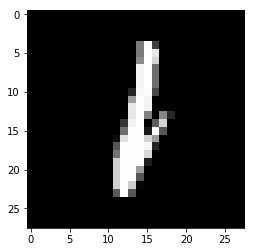

In [7]:
# check that all is bueno
test = data_list[0][np.random.randint(low = 0, high = data_list[0].shape[0]), :]
plt.imshow(test.reshape(28,28), cmap='gray')
plt.show()

In [11]:
model = log_reg(step_size = .01, epochs = 1000, activation_function = "softmax", batch_size = 32)
model.fit(data_list[0], data_list[1])

In [15]:
w = model.w.reshape(785, 10)

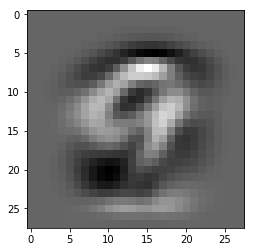

In [31]:
for i in range(10):
    

plt.imshow(w[1:, 9].reshape(28, 28), cmap = 'gray')
plt.show()

In [17]:
28*28

784

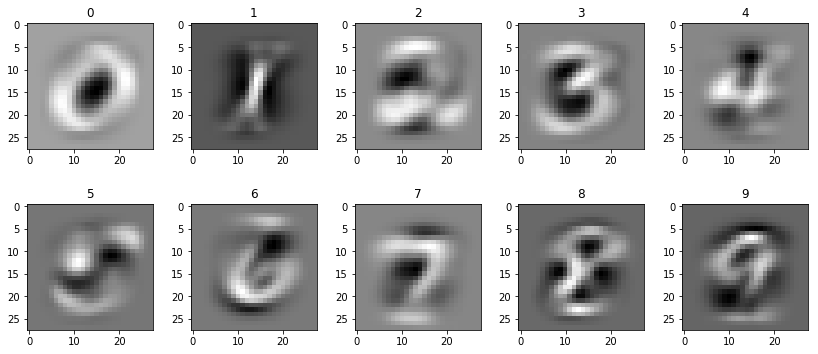

In [50]:
fig, axs = plt.subplots(2,5, figsize=(14, 10), edgecolor='k')
fig.subplots_adjust(hspace = -.5, wspace=.3)

axs = axs.ravel()

for i in range(10):
    axs[i].imshow(w[1:, i].reshape(28, 28), cmap = 'gray')
    axs[i].set_title(str(i))
for a in axs:
    a.set_aspect('equal')
